In [5]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm
from ultralytics import YOLO

%matplotlib inline

In [2]:
def plot_frame(image: np.ndarray, figsize=(8, 6), title=None):
    plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title, fontsize=12)
    plt.imshow(image)

In [6]:
yolo_model = YOLO("yolov8x.pt")

100%|████████████████████████████████████████| 131M/131M [00:03<00:00, 43.3MB/s]


In [7]:
vpath = '/media/alexey/HDDData/datasets/railway/RZD_Alarm/side_cam/08_29_43.mp4'

stream = cv2.VideoCapture(vpath, cv2.CAP_FFMPEG)

stream_width = int(stream.get(cv2.CAP_PROP_FRAME_WIDTH))
stream_height = int(stream.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(stream.get(cv2.CAP_PROP_FPS))
print('FPS: {}, W: {}, H: {}'.format(fps, stream_width, stream_height))

FPS: 12, W: 1920, H: 1080


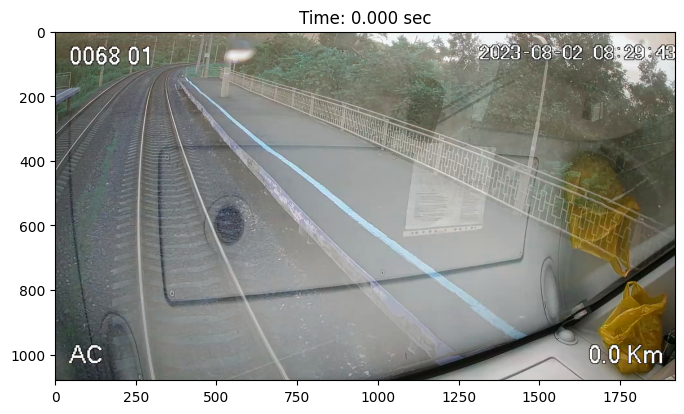

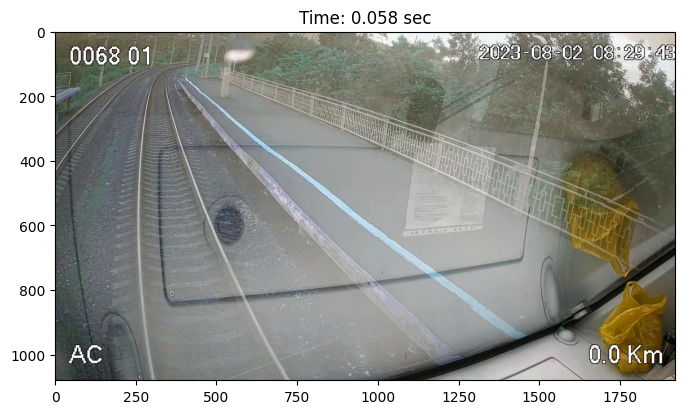

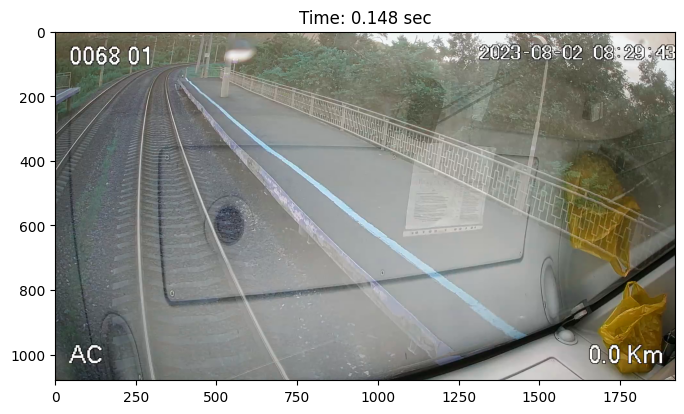

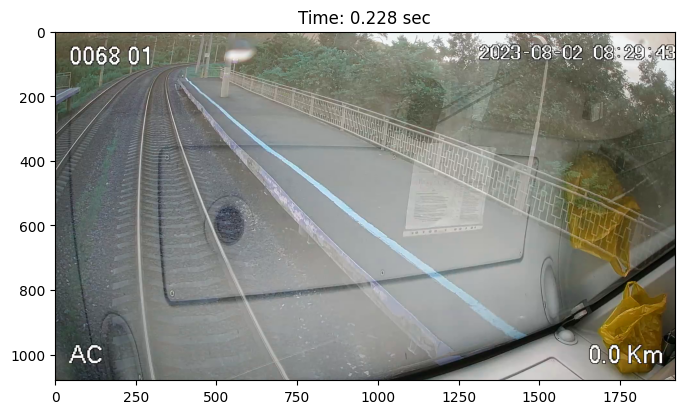

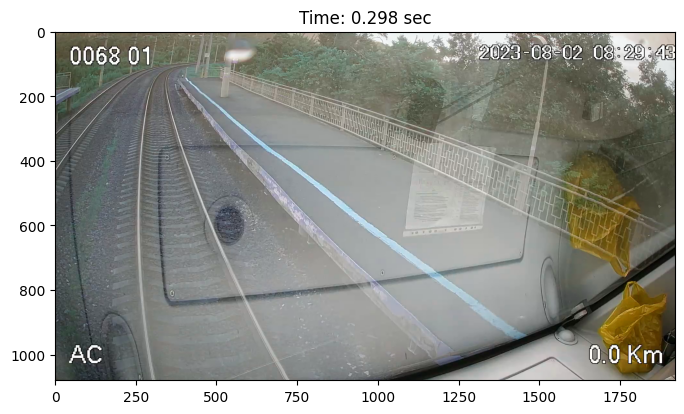

In [4]:
for _ in range(5):
    grabbed, frame = stream.read()
    
    if not grabbed:
        break
        
    timestamp = stream.get(cv2.CAP_PROP_POS_MSEC) / 1000.0

    plot_frame(frame, title='Time: {:.3f} sec'.format(timestamp))
    
plt.show()

stream.release()